In [1]:
!pip install unrar
!unrar x /content/UTKFace.rar

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  UTKFace/53_0_2_20170112221930338.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_2_20170116192925824.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_2_20170116192934154.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_2_20170119205816456.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170104220848558.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170109132854337.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170109142546975.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170112220530017.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170117171834099.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace/53_0_3_20170119164018532.jpg.chip.jpg                 59%  OK 
Extracting  UTKFace

Importar librerias y crear un diccionario para ayudarnos a sacar info del datset 
**texto en negrita**




In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dataset_folder_name = 'UTKFace'
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

**Definir funcion para extraer datos del datset**

In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [4]:
df = parse_dataset("/content/UTKFace")
df.head()

,age,gender,race,file
0,9.0,male,white,/content/UTKFace/9_0_0_20170110220623658.jpg.c...
1,89.0,female,indian,/content/UTKFace/89_1_3_20170110182042731.jpg....
2,19.0,female,black,/content/UTKFace/19_1_1_20170114030819891.jpg....
3,50.0,male,asian,/content/UTKFace/50_0_2_20170116191148275.jpg....
4,2.0,male,others,/content/UTKFace/2_0_4_20161221194951087.jpg.c...


drop race and gender

In [5]:
df.drop(['gender','race'], axis=1, inplace=True)


# **Visualización de datos**

In [6]:
!pip install plotly


In [7]:
import plotly.graph_objects as go

In [ ]:
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

RAZA

In [ ]:
plot_distribution(df['race'])


GENERO

In [ ]:
plot_distribution(df['gender'])


EDAD

In [8]:
import plotly.express as px


In [9]:
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

Crear un objeto que trabaje como generador de datos para el dataset. Genra batches de datos para alimentar el modelo con imagenes y las etiquetas.

In [10]:
!pip install keras

In [11]:
!pip install tensorflow


In [12]:
from tensorflow.keras.utils import to_categorical

In [13]:
from PIL import Image

In [15]:
class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        
        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages = [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages)]
                    images, ages = [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 

**Contrucción del modelo**


In [16]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

In [19]:
class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x
    
    
    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        age_branch = self.build_age_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [age_branch],
                     name="face_net")
        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

**Entrenamiento**

In [22]:
from keras.optimizers import Adam
init_lr = 1e-4
epochs = 80
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  },
              loss_weights={
                  'age_output': 4., 
                  },
              metrics={
                  'age_output': 'mae', 
                  })

In [23]:
from keras.callbacks import ModelCheckpoint
batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/80
362/362 [==============================] - 424s 1s/step - loss: 12.8499 - mae: 1.3912 - val_loss: 10.1972 - val_mae: 1.3506
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/80
362/362 [==============================] - 421s 1s/step - loss: 7.5218 - mae: 1.0581 - val_loss: 20.0334 - val_mae: 1.2648
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/80
362/362 [==============================] - 419s 1s/step - loss: 5.8363 - mae: 0.9267 - val_loss: 32.3559 - val_mae: 1.4208
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 4/80
362/362 [==============================] - 417s 1s/step - loss: 4.7779 - mae: 0.8280 - val_loss: 18.1028 - val_mae: 1.0823
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 5/80
362/362 [==============================] - 422s 1s/step - loss: 3.6332 - mae: 0.7218 - val_loss: 16.8846 - val_mae: 0.9396
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 6/80
362/362 [====

In [24]:
model.save('modelo_utk_age')

INFO:tensorflow:Assets written to: modelo_utk_age/assets


In [26]:
!zip -r modelo_utk_age.zip modelo_utk_age

  adding: modelo_utk_age/ (stored 0%)
  adding: modelo_utk_age/saved_model.pb (deflated 90%)
  adding: modelo_utk_age/assets/ (stored 0%)
  adding: modelo_utk_age/keras_metadata.pb (deflated 93%)
  adding: modelo_utk_age/variables/ (stored 0%)
  adding: modelo_utk_age/variables/variables.index (deflated 72%)
  adding: modelo_utk_age/variables/variables.data-00000-of-00001 (deflated 11%)


RACE ACCURACY

In [ ]:
pip install plotly==4.14.3

     |████████████████████████████████| 13.2MB 233kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [27]:
import matplotlib.pyplot as plt


In [28]:
import plotly.graph_objects as go

In [29]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

GENDER ACCURACY

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

AGE MAE

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mean_absolute_error'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mean_absolute_error'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

OVERALL LOSS

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

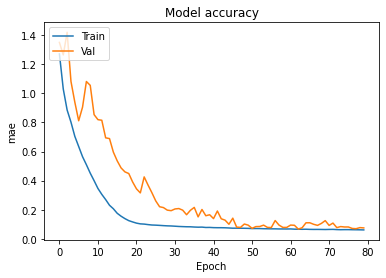

In [32]:
# Plot training and validation accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
# plt.ylim(0, 1)
plt.show()